In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('course_lead_scoring.csv')

In [5]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [8]:
categorical = ['lead_source','industry','employment_status','location']
numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']

In [9]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [10]:
df[categorical+numerical].isnull().sum()

lead_source                 0
industry                    0
employment_status           0
location                    0
number_of_courses_viewed    0
annual_income               0
interaction_count           0
lead_score                  0
dtype: int64

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [13]:
scores = []
for variable in df_train[numerical]:
    score = roc_auc_score(y_train,df_train[variable].values)
    if score < 0.5:
        score = -score
    scores.append(score)
    print(f'{variable}: {round(score,3)}')

number_of_courses_viewed: 0.764
annual_income: 0.552
interaction_count: 0.738
lead_score: 0.614


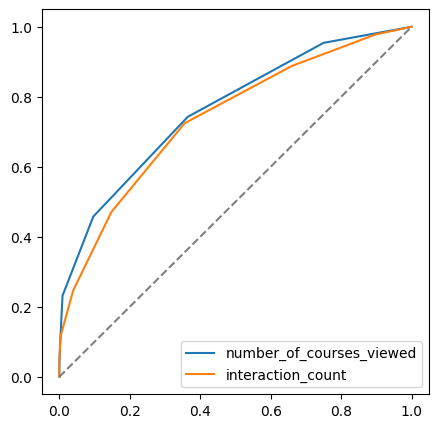

In [14]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.number_of_courses_viewed)
plt.plot(fpr, tpr, label='number_of_courses_viewed')

fpr, tpr, _ = roc_curve(y_train, df_train.interaction_count)
plt.plot(fpr, tpr, label='interaction_count')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

number_of_courses_viewed has the highest AUC

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92


In [15]:
from sklearn.feature_extraction import DictVectorizer

In [16]:
dv = DictVectorizer()
X_train = dv.fit_transform(df_train.to_dict(orient='records'))

X_val = dv.transform(df_val.to_dict(orient='records'))

model = LogisticRegression(C=1.0, max_iter=1000)
model.fit(X_train,y_train)

y_pred = model.predict_proba(X_val)[:,1]

round(roc_auc_score(y_val,y_pred),2)

/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.92

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [17]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t,tp, fp, fn, tn))
    columns = ('threshold','tp','fp','fn','tn')
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores

In [18]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [19]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,171,122,0,0
10,0.1,168,94,3,28
20,0.2,165,71,6,51
30,0.3,164,49,7,73
40,0.4,158,33,13,89
50,0.5,153,27,18,95
60,0.6,143,15,28,107
70,0.7,135,11,36,111
80,0.8,128,7,43,115
90,0.9,102,6,69,116


In [20]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

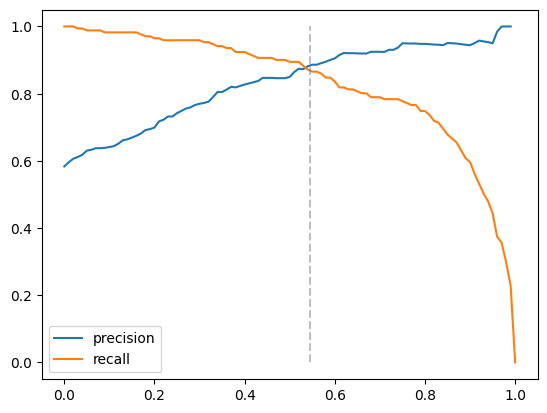

In [21]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.545, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [34]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        p = tp / (tp + fp) 
        r = tp / (tp + fn) 
        f1 = 2 * (p * r / (p + r))

        scores.append((t, tp, fp, fn, tn, p, r, f1))
    
    columns = ('threshold', 'tp', 'fp', 'fn', 'tn', 'p', 'r', 'f1')
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores

In [35]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

/tmp/ipykernel_30225/2417906222.py:19: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


In [46]:
df_scores.sort_values('f1', ascending=False)

,threshold,tp,fp,fn,tn,p,r,f1
52,0.52,153,22,18,100,0.874286,0.894737,0.884393
51,0.51,153,24,18,98,0.864407,0.894737,0.879310
53,0.53,151,22,20,100,0.872832,0.883041,0.877907
54,0.54,149,20,22,102,0.881657,0.871345,0.876471
56,0.56,148,19,23,103,0.886228,0.865497,0.875740
...,...,...,...,...,...,...,...,...
96,0.96,64,1,107,121,0.984615,0.374269,0.542373
97,0.97,61,0,110,122,1.000000,0.356725,0.525862
98,0.98,51,0,120,122,1.000000,0.298246,0.459459
99,0.99,39,0,132,122,1.000000,0.228070,0.371429
